In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import re

# Load the train and test datasets
train_df = pd.read_csv("/bin/Corona_NLP_train.csv", encoding='ISO-8859-1')
test_df = pd.read_csv("/bin/Corona_NLP_test.csv", encoding='ISO-8859-1')

# Function to clean tweets by removing @ mentions
def clean_tweet(text):
    text = re.sub(r'@\w+', '', text)
    return text

# Apply cleaning to both training and testing datasets
train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(clean_tweet)
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(clean_tweet)

# Preprocessing: Select relevant columns and handle missing data
train_df = train_df[['OriginalTweet', 'Sentiment']].dropna()
test_df = test_df[['OriginalTweet', 'Sentiment']].dropna()

# Label encoding for the sentiment column in both train and test data
label_encoder = LabelEncoder()
train_df['Sentiment'] = label_encoder.fit_transform(train_df['Sentiment'])
test_df['Sentiment'] = label_encoder.transform(test_df['Sentiment'])

# Separate features and labels
X_train = train_df['OriginalTweet'].values
y_train = train_df['Sentiment'].values
X_test = test_df['OriginalTweet'].values
y_test = test_df['Sentiment'].values

# Text Tokenization and Padding
max_words = 5000  # Vocabulary size
max_len = 50      # Maximum length of tweet sequences

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Only fit on train data
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Define the model
num_classes = len(label_encoder.classes_)  # Number of unique sentiment classes

model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),  # Smaller LSTM layer with dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # L2 regularization
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # For multi-class classification
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    epochs=20,  # Increased epochs with early stopping
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on the test data
y_pred = np.argmax(model.predict(X_test_pad), axis=-1)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Function to predict sentiment of a user-input tweet
def predict_sentiment(tweet):
    tweet_seq = tokenizer.texts_to_sequences([tweet])
    tweet_pad = pad_sequences(tweet_seq, maxlen=max_len, padding='post')
    prediction = model.predict(tweet_pad)
    sentiment_class = np.argmax(prediction, axis=-1)[0]
    sentiment = label_encoder.inverse_transform([sentiment_class])[0]
    return sentiment


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1287/1287 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - accuracy: 0.2847 - loss: 1.5683 - val_accuracy: 0.3694 - val_loss: 1.3875 - learning_rate: 0.0010
Epoch 2/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.4323 - loss: 1.3274 - val_accuracy: 0.6116 - val_loss: 1.0064 - learning_rate: 0.0010
Epoch 3/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - accuracy: 0.6412 - loss: 0.9490 - val_accuracy: 0.7067 - val_loss: 0.8420 - learning_rate: 0.0010
Epoch 4/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.7131 - loss: 0.8407 - val_accuracy: 0.7204 - val_loss: 0.8076 - learning_rate: 0.0010
Epoch 5/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7394 - loss: 0.7741 - val_accuracy: 0.7346 - val_loss: 0.7968 - learning_rate: 0.0010
Epoch 6/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7633 - loss: 0.7244 - val_accuracy: 0.7357 - val_loss: 0.7993 - learning_rate: 0.0010
Epoch 7/20
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7791 

In [12]:
while True:
    user_tweet = input("Enter a tweet to analyze sentiment (or type 'stop' to exit): ")
    if user_tweet.lower() == 'stop':
        print("Exiting sentiment analysis.")
        break
    predicted_sentiment = predict_sentiment(user_tweet)
    print(f"The sentiment of the tweet is: {predicted_sentiment}")


Enter a tweet to analyze sentiment (or type 'stop' to exit): covid days are hard to pass yet we had sweet memories because we were with our families
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
The sentiment of the tweet is: Positive
Enter a tweet to analyze sentiment (or type 'stop' to exit): stop
Exiting sentiment analysis.


Epoch 1/5
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.7693 - loss: 0.7149 - val_accuracy: 0.7264 - val_loss: 0.7997
Epoch 2/5
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.7794 - loss: 0.6869 - val_accuracy: 0.7317 - val_loss: 0.7971
Epoch 3/5
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7937 - loss: 0.6664 - val_accuracy: 0.7304 - val_loss: 0.8036
Epoch 4/5
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.7929 - loss: 0.6596 - val_accuracy: 0.7354 - val_loss: 0.8073
Epoch 5/5
1287/1287 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.7974 - loss: 0.6451 - val_accuracy: 0.7285 - val_loss: 0.8147


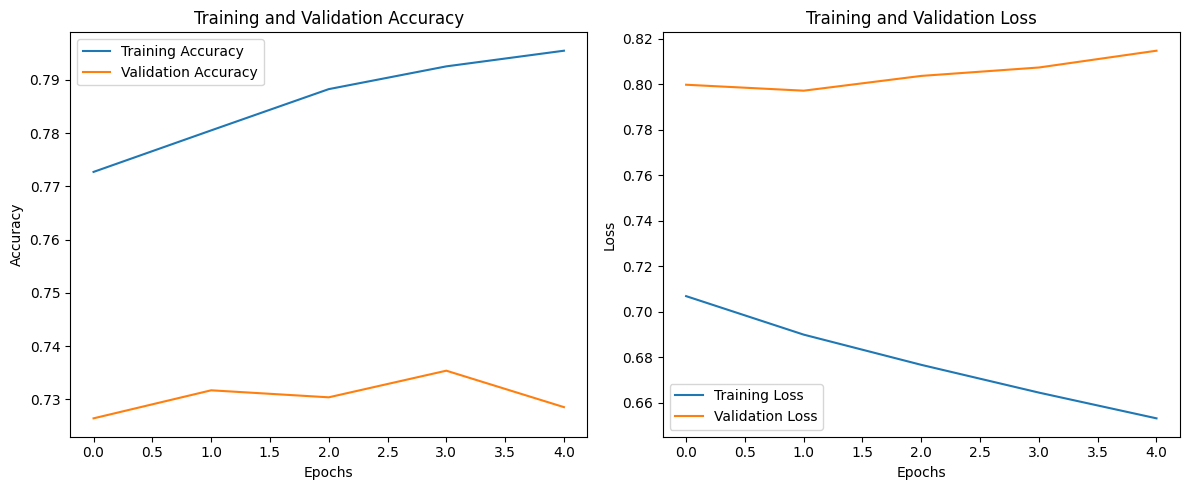

In [13]:
import matplotlib.pyplot as plt

# Train the model and capture the history
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test))

# Plotting accuracy graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
